In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import matplotlib.patches as mpatches

from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = ct.NOT_DELIVERYING_PENALTY 

## System initializer

In [3]:
def initialize_test_system(noise = False, seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = noise
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
print("States space dimension: ",toy_system.states_dim)
print("Actions space dimension: ",toy_system.actions_dim)
a_s_dim = toy_system.states_dim * toy_system.actions_dim
print("States-Actions space dimension: ",a_s_dim)

States space dimension:  36864
Actions space dimension:  36
States-Actions space dimension:  1327104


In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print("Tank max loads: ",system.tank_max_loads())
print("Tank dayly rates: ",system.tank_rates())
print("Truck max loads: ",system.truck_max_loads())
print("Graph: \n",system.graph)
print("Weights: \n", system.weights)

Tank max loads:  [100.0, 200.0, 100.0, 800.0, 200.0]
Tank dayly rates:  [16.5, 4.0, 10.500000000000002, 84.00000000000001, 34.0]
Truck max loads:  [70.0, 130.0]
Graph: 
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
Weights: 
 [[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

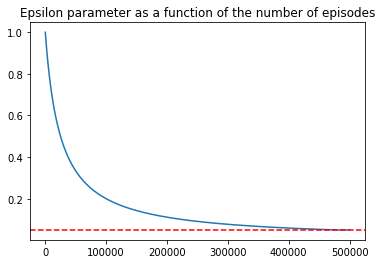

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 5*10**5
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3 #3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 222
add_noise = False

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system(noise = add_noise, seed = seed)
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

if train_epsilon == False and retrain == False:
     pass
else: # Create directories for the simulations' outputs

    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing

    if not os.path.exists(simulation_directory):
        os.makedirs(simulation_directory)
        os.makedirs(simulation_directory + '/Q-dictionaries')
        os.makedirs(simulation_directory + '/discrewards')
        os.makedirs(simulation_directory + '/vis')

#     else:
#         raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")


#     ut.save_obj(toy_system, simulation_directory+"/system-sim"+"{}".format(simulation_id)) 

#     # Output headers to file
#     with open(rewards_file,'w') as f:
#          np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')         


In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward, _,_,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward, _ ,_,_ = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward,_ ,_,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print("Training finished. Total episodes: {}. Elapsed time: {} minutes.".format(n_episodes,round(end_time/60., round_time)))        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
# if train_epsilon == False and retrain == False:
#     pass
# elif train_epsilon == True and retrain == False:
#     episodic_train_Q_epsilon()
# elif train_epsilon == False and retrain == True:
#     Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode_retrain))
#     episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
# else:
#     raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    

Episode: 100. Elapsed time  0.08  minuts. epsilon 0.9961 Discounted reward:  -24.27377691294009
Episode: 200. Elapsed time  0.18  minuts. epsilon 0.9921 Discounted reward:  -23.480697319077976
Episode: 300. Elapsed time  0.3  minuts. epsilon 0.9882 Discounted reward:  -22.958174747928883
Episode: 400. Elapsed time  0.43  minuts. epsilon 0.9843 Discounted reward:  -22.89470608707027
Episode: 500. Elapsed time  0.59  minuts. epsilon 0.9804 Discounted reward:  -25.71042484922833
Episode: 600. Elapsed time  0.75  minuts. epsilon 0.9766 Discounted reward:  -27.302902930059975
Episode: 700. Elapsed time  0.93  minuts. epsilon 0.9728 Discounted reward:  -26.629119224584134
Episode: 800. Elapsed time  1.12  minuts. epsilon 0.969 Discounted reward:  -26.854917737020376
Episode: 900. Elapsed time  1.32  minuts. epsilon 0.9653 Discounted reward:  -21.45729896075543
Episode: 1000. Elapsed time  1.53  minuts. epsilon 0.9616 Discounted reward:  -25.589420117184055
Episode: 1100. Elapsed time  1.75  

Episode: 8500. Elapsed time  33.19  minuts. epsilon 0.7463 Discounted reward:  -25.64816178710881
Episode: 8600. Elapsed time  33.76  minuts. epsilon 0.7441 Discounted reward:  -15.527057402389463
Episode: 8700. Elapsed time  34.31  minuts. epsilon 0.7419 Discounted reward:  -17.82468783596199
Episode: 8800. Elapsed time  34.87  minuts. epsilon 0.7397 Discounted reward:  -20.45419172639926
Episode: 8900. Elapsed time  35.42  minuts. epsilon 0.7375 Discounted reward:  -21.029200685800856
Episode: 9000. Elapsed time  35.99  minuts. epsilon 0.7353 Discounted reward:  -28.357338526066435
Episode: 9100. Elapsed time  36.55  minuts. epsilon 0.7332 Discounted reward:  -21.14482240815307
Episode: 9200. Elapsed time  37.13  minuts. epsilon 0.731 Discounted reward:  -23.33337447521507
Episode: 9300. Elapsed time  37.7  minuts. epsilon 0.7289 Discounted reward:  -23.224485036675148
Episode: 9400. Elapsed time  38.26  minuts. epsilon 0.7268 Discounted reward:  -16.440259542289358
Episode: 9500. El

Episode: 16800. Elapsed time  86.18  minuts. epsilon 0.5981 Discounted reward:  -14.505473303089794
Episode: 16900. Elapsed time  86.86  minuts. epsilon 0.5967 Discounted reward:  -12.976738133367324
Episode: 17000. Elapsed time  87.53  minuts. epsilon 0.5953 Discounted reward:  -23.496603010297648
Episode: 17100. Elapsed time  88.22  minuts. epsilon 0.5938 Discounted reward:  -18.081060094115667
Episode: 17200. Elapsed time  88.91  minuts. epsilon 0.5924 Discounted reward:  -17.16988169250978
Episode: 17300. Elapsed time  89.7  minuts. epsilon 0.591 Discounted reward:  -14.313209681506084
Episode: 17400. Elapsed time  90.4  minuts. epsilon 0.5896 Discounted reward:  -17.118601853245423
Episode: 17500. Elapsed time  91.12  minuts. epsilon 0.5882 Discounted reward:  -18.935904232070776
Episode: 17600. Elapsed time  91.83  minuts. epsilon 0.5869 Discounted reward:  -17.391250743794153
Episode: 17700. Elapsed time  92.54  minuts. epsilon 0.5855 Discounted reward:  -19.458395092808505
Epis

Episode: 25000. Elapsed time  147.4  minuts. epsilon 0.5 Discounted reward:  -15.021653141159792
Episode: 25100. Elapsed time  148.19  minuts. epsilon 0.499 Discounted reward:  -18.366211922661837
Episode: 25200. Elapsed time  148.96  minuts. epsilon 0.498 Discounted reward:  -19.24785996083647
Episode: 25300. Elapsed time  149.76  minuts. epsilon 0.497 Discounted reward:  -16.320134271223324
Episode: 25400. Elapsed time  150.53  minuts. epsilon 0.496 Discounted reward:  -13.369763284056095
Episode: 25500. Elapsed time  151.33  minuts. epsilon 0.4951 Discounted reward:  -24.120654203927234
Episode: 25600. Elapsed time  152.11  minuts. epsilon 0.4941 Discounted reward:  -20.352935984749227
Episode: 25700. Elapsed time  152.88  minuts. epsilon 0.4931 Discounted reward:  -14.398649764659856
Episode: 25800. Elapsed time  153.64  minuts. epsilon 0.4921 Discounted reward:  -16.96910794464155
Episode: 25900. Elapsed time  154.38  minuts. epsilon 0.4912 Discounted reward:  -13.52589309012812
E

Episode: 33200. Elapsed time  213.74  minuts. epsilon 0.4296 Discounted reward:  -15.89679974446436
Episode: 33300. Elapsed time  214.57  minuts. epsilon 0.4288 Discounted reward:  -14.74122531284241
Episode: 33400. Elapsed time  215.39  minuts. epsilon 0.4281 Discounted reward:  -13.818247714759899
Episode: 33500. Elapsed time  216.21  minuts. epsilon 0.4274 Discounted reward:  -21.522389157779777
Episode: 33600. Elapsed time  217.02  minuts. epsilon 0.4266 Discounted reward:  -20.866440965393394
Episode: 33700. Elapsed time  217.87  minuts. epsilon 0.4259 Discounted reward:  -16.11885360569691
Episode: 33800. Elapsed time  218.7  minuts. epsilon 0.4252 Discounted reward:  -19.221999912099378
Episode: 33900. Elapsed time  219.54  minuts. epsilon 0.4245 Discounted reward:  -15.131361705810084
Episode: 34000. Elapsed time  220.39  minuts. epsilon 0.4237 Discounted reward:  -15.21802591760854
Episode: 34100. Elapsed time  221.24  minuts. epsilon 0.423 Discounted reward:  -15.847682431496

Episode: 41400. Elapsed time  283.62  minuts. epsilon 0.3765 Discounted reward:  -18.23582209020002
Episode: 41500. Elapsed time  284.49  minuts. epsilon 0.3759 Discounted reward:  -12.084718904167007
Episode: 41600. Elapsed time  285.36  minuts. epsilon 0.3754 Discounted reward:  -14.946431505424625
Episode: 41700. Elapsed time  286.24  minuts. epsilon 0.3748 Discounted reward:  -15.719528787949
Episode: 41800. Elapsed time  287.16  minuts. epsilon 0.3743 Discounted reward:  -11.689249212448752
Episode: 41900. Elapsed time  288.04  minuts. epsilon 0.3737 Discounted reward:  -14.180606561362996
Episode: 42000. Elapsed time  288.93  minuts. epsilon 0.3731 Discounted reward:  -19.141245696875217
Episode: 42100. Elapsed time  289.81  minuts. epsilon 0.3726 Discounted reward:  -12.426904027370252
Episode: 42200. Elapsed time  290.68  minuts. epsilon 0.372 Discounted reward:  -12.132589959803436
Episode: 42300. Elapsed time  291.56  minuts. epsilon 0.3715 Discounted reward:  -9.848874535342

Episode: 49600. Elapsed time  356.08  minuts. epsilon 0.3351 Discounted reward:  -15.222239202969318
Episode: 49700. Elapsed time  356.99  minuts. epsilon 0.3347 Discounted reward:  -14.780624321233912
Episode: 49800. Elapsed time  357.9  minuts. epsilon 0.3342 Discounted reward:  -14.26842677910264
Episode: 49900. Elapsed time  358.84  minuts. epsilon 0.3338 Discounted reward:  -11.732315621704931
Episode: 50000. Elapsed time  359.84  minuts. epsilon 0.3333 Discounted reward:  -10.798294174106044
Episode: 50100. Elapsed time  360.86  minuts. epsilon 0.3329 Discounted reward:  -20.402262660238122
Episode: 50200. Elapsed time  361.86  minuts. epsilon 0.3325 Discounted reward:  -13.879670476631988
Episode: 50300. Elapsed time  362.84  minuts. epsilon 0.332 Discounted reward:  -17.832072363644446
Episode: 50400. Elapsed time  363.73  minuts. epsilon 0.3316 Discounted reward:  -14.779029021556822
Episode: 50500. Elapsed time  364.64  minuts. epsilon 0.3311 Discounted reward:  -14.645656034

Episode: 57800. Elapsed time  432.27  minuts. epsilon 0.3019 Discounted reward:  -12.465419800375011
Episode: 57900. Elapsed time  433.28  minuts. epsilon 0.3016 Discounted reward:  -14.217797887725558
Episode: 58000. Elapsed time  434.31  minuts. epsilon 0.3012 Discounted reward:  -16.101138422023883
Episode: 58100. Elapsed time  435.35  minuts. epsilon 0.3008 Discounted reward:  -13.822676145108966
Episode: 58200. Elapsed time  436.37  minuts. epsilon 0.3005 Discounted reward:  -20.401595605115748
Episode: 58300. Elapsed time  437.29  minuts. epsilon 0.3001 Discounted reward:  -10.787922438501385
Episode: 58400. Elapsed time  438.21  minuts. epsilon 0.2998 Discounted reward:  -10.512564490813423
Episode: 58500. Elapsed time  439.14  minuts. epsilon 0.2994 Discounted reward:  -13.54739023362739
Episode: 58600. Elapsed time  440.06  minuts. epsilon 0.299 Discounted reward:  -13.153563056676681
Episode: 58700. Elapsed time  440.96  minuts. epsilon 0.2987 Discounted reward:  -13.91758382

Episode: 66000. Elapsed time  510.07  minuts. epsilon 0.2747 Discounted reward:  -11.06138506985267
Episode: 66100. Elapsed time  511.02  minuts. epsilon 0.2744 Discounted reward:  -14.864459641481469
Episode: 66200. Elapsed time  511.99  minuts. epsilon 0.2741 Discounted reward:  -14.765461686829724
Episode: 66300. Elapsed time  512.94  minuts. epsilon 0.2738 Discounted reward:  -11.01768552294714
Episode: 66400. Elapsed time  513.87  minuts. epsilon 0.2735 Discounted reward:  -13.647627189515584
Episode: 66500. Elapsed time  514.82  minuts. epsilon 0.2732 Discounted reward:  -17.956309600213554
Episode: 66600. Elapsed time  515.74  minuts. epsilon 0.2729 Discounted reward:  -10.664661941574384
Episode: 66700. Elapsed time  516.67  minuts. epsilon 0.2726 Discounted reward:  -11.53663169011487
Episode: 66800. Elapsed time  517.62  minuts. epsilon 0.2723 Discounted reward:  -10.260279326608666
Episode: 66900. Elapsed time  518.59  minuts. epsilon 0.272 Discounted reward:  -16.3423991982

Episode: 74200. Elapsed time  588.97  minuts. epsilon 0.252 Discounted reward:  -12.303613681855543
Episode: 74300. Elapsed time  589.94  minuts. epsilon 0.2518 Discounted reward:  -15.218867699331824
Episode: 74400. Elapsed time  590.9  minuts. epsilon 0.2515 Discounted reward:  -13.399258492008377
Episode: 74500. Elapsed time  591.87  minuts. epsilon 0.2513 Discounted reward:  -9.809960714994704
Episode: 74600. Elapsed time  592.86  minuts. epsilon 0.251 Discounted reward:  -15.48445661063934
Episode: 74700. Elapsed time  593.83  minuts. epsilon 0.2508 Discounted reward:  -12.598158208166419
Episode: 74800. Elapsed time  594.8  minuts. epsilon 0.2505 Discounted reward:  -14.202685564243867
Episode: 74900. Elapsed time  595.77  minuts. epsilon 0.2503 Discounted reward:  -12.453509161609878
Episode: 75000. Elapsed time  596.75  minuts. epsilon 0.25 Discounted reward:  -7.546426977937778
Episode: 75100. Elapsed time  597.7  minuts. epsilon 0.2498 Discounted reward:  -9.840162676121425
E

Episode: 82400. Elapsed time  668.32  minuts. epsilon 0.2328 Discounted reward:  -12.77203638202887
Episode: 82500. Elapsed time  669.29  minuts. epsilon 0.2326 Discounted reward:  -10.327659371897159
Episode: 82600. Elapsed time  670.26  minuts. epsilon 0.2323 Discounted reward:  -18.310457647040256
Episode: 82700. Elapsed time  671.22  minuts. epsilon 0.2321 Discounted reward:  -10.83522035613463
Episode: 82800. Elapsed time  672.2  minuts. epsilon 0.2319 Discounted reward:  -11.878031941994912
Episode: 82900. Elapsed time  673.19  minuts. epsilon 0.2317 Discounted reward:  -9.577567283210199
Episode: 83000. Elapsed time  674.16  minuts. epsilon 0.2315 Discounted reward:  -11.547213918903545
Episode: 83100. Elapsed time  675.15  minuts. epsilon 0.2313 Discounted reward:  -13.543879457499763
Episode: 83200. Elapsed time  676.13  minuts. epsilon 0.2311 Discounted reward:  -17.82453333997346
Episode: 83300. Elapsed time  677.15  minuts. epsilon 0.2308 Discounted reward:  -15.55399649250

Episode: 90600. Elapsed time  748.73  minuts. epsilon 0.2163 Discounted reward:  -12.83111052544412
Episode: 90700. Elapsed time  749.72  minuts. epsilon 0.2161 Discounted reward:  -13.171705096467715
Episode: 90800. Elapsed time  750.71  minuts. epsilon 0.2159 Discounted reward:  -12.514697987085624
Episode: 90900. Elapsed time  751.7  minuts. epsilon 0.2157 Discounted reward:  -10.904712321983462
Episode: 91000. Elapsed time  752.7  minuts. epsilon 0.2155 Discounted reward:  -11.217543911071639
Episode: 91100. Elapsed time  753.68  minuts. epsilon 0.2153 Discounted reward:  -13.79079237795646
Episode: 91200. Elapsed time  754.64  minuts. epsilon 0.2151 Discounted reward:  -10.37018709572093
Episode: 91300. Elapsed time  755.62  minuts. epsilon 0.215 Discounted reward:  -15.860950640070598
Episode: 91400. Elapsed time  756.6  minuts. epsilon 0.2148 Discounted reward:  -13.92737208059952
Episode: 91500. Elapsed time  757.59  minuts. epsilon 0.2146 Discounted reward:  -15.52705849908442

Episode: 98800. Elapsed time  830.35  minuts. epsilon 0.2019 Discounted reward:  -10.972637697591752
Episode: 98900. Elapsed time  831.33  minuts. epsilon 0.2018 Discounted reward:  -16.664097186012146
Episode: 99000. Elapsed time  832.3  minuts. epsilon 0.2016 Discounted reward:  -16.897614318366937
Episode: 99100. Elapsed time  833.3  minuts. epsilon 0.2015 Discounted reward:  -13.735286737591656
Episode: 99200. Elapsed time  834.26  minuts. epsilon 0.2013 Discounted reward:  -13.803768216891196
Episode: 99300. Elapsed time  835.26  minuts. epsilon 0.2011 Discounted reward:  -15.012249751887031
Episode: 99400. Elapsed time  836.28  minuts. epsilon 0.201 Discounted reward:  -9.48376979028168
Episode: 99500. Elapsed time  837.29  minuts. epsilon 0.2008 Discounted reward:  -15.149947208625427
Episode: 99600. Elapsed time  838.29  minuts. epsilon 0.2006 Discounted reward:  -12.803704828499638
Episode: 99700. Elapsed time  839.29  minuts. epsilon 0.2005 Discounted reward:  -11.77286016746

Episode: 106900. Elapsed time  911.99  minuts. epsilon 0.1895 Discounted reward:  -11.80125863233627
Episode: 107000. Elapsed time  913.0  minuts. epsilon 0.1894 Discounted reward:  -10.319710860237661
Episode: 107100. Elapsed time  914.02  minuts. epsilon 0.1893 Discounted reward:  -14.080981073303242
Episode: 107200. Elapsed time  915.03  minuts. epsilon 0.1891 Discounted reward:  -11.894549849171531
Episode: 107300. Elapsed time  916.02  minuts. epsilon 0.189 Discounted reward:  -14.294998224276737
Episode: 107400. Elapsed time  917.02  minuts. epsilon 0.1888 Discounted reward:  -12.374612260690219
Episode: 107500. Elapsed time  918.03  minuts. epsilon 0.1887 Discounted reward:  -10.719439434252209
Episode: 107600. Elapsed time  919.03  minuts. epsilon 0.1885 Discounted reward:  -10.757395190267156
Episode: 107700. Elapsed time  920.03  minuts. epsilon 0.1884 Discounted reward:  -10.03811426659219
Episode: 107800. Elapsed time  921.03  minuts. epsilon 0.1883 Discounted reward:  -18.

Episode: 115000. Elapsed time  993.83  minuts. epsilon 0.1786 Discounted reward:  -11.833512145584947
Episode: 115100. Elapsed time  994.84  minuts. epsilon 0.1784 Discounted reward:  -12.634086336472295
Episode: 115200. Elapsed time  995.89  minuts. epsilon 0.1783 Discounted reward:  -13.553515977351056
Episode: 115300. Elapsed time  996.89  minuts. epsilon 0.1782 Discounted reward:  -12.7910956189208
Episode: 115400. Elapsed time  997.89  minuts. epsilon 0.1781 Discounted reward:  -11.16394537076486
Episode: 115500. Elapsed time  998.9  minuts. epsilon 0.1779 Discounted reward:  -16.95618539647923
Episode: 115600. Elapsed time  999.91  minuts. epsilon 0.1778 Discounted reward:  -8.907056994860811
Episode: 115700. Elapsed time  1000.92  minuts. epsilon 0.1777 Discounted reward:  -12.568689030382117
Episode: 115800. Elapsed time  1001.94  minuts. epsilon 0.1776 Discounted reward:  -11.475033985757578
Episode: 115900. Elapsed time  1002.99  minuts. epsilon 0.1774 Discounted reward:  -12

Episode: 123000. Elapsed time  1075.61  minuts. epsilon 0.1689 Discounted reward:  -14.487200960115652
Episode: 123100. Elapsed time  1076.64  minuts. epsilon 0.1688 Discounted reward:  -13.818137499655506
Episode: 123200. Elapsed time  1077.66  minuts. epsilon 0.1687 Discounted reward:  -10.866767663786263
Episode: 123300. Elapsed time  1078.69  minuts. epsilon 0.1686 Discounted reward:  -9.73828605944543
Episode: 123400. Elapsed time  1079.71  minuts. epsilon 0.1685 Discounted reward:  -10.88530707884606
Episode: 123500. Elapsed time  1080.74  minuts. epsilon 0.1684 Discounted reward:  -11.864180365784216
Episode: 123600. Elapsed time  1081.76  minuts. epsilon 0.1682 Discounted reward:  -17.521993592660476
Episode: 123700. Elapsed time  1082.79  minuts. epsilon 0.1681 Discounted reward:  -12.404416266517854
Episode: 123800. Elapsed time  1083.8  minuts. epsilon 0.168 Discounted reward:  -11.601273076418432
Episode: 123900. Elapsed time  1084.83  minuts. epsilon 0.1679 Discounted rewa

Episode: 131000. Elapsed time  1158.03  minuts. epsilon 0.1603 Discounted reward:  -11.433441426824114
Episode: 131100. Elapsed time  1159.06  minuts. epsilon 0.1602 Discounted reward:  -10.972537565120012
Episode: 131200. Elapsed time  1160.07  minuts. epsilon 0.1601 Discounted reward:  -11.491721578420634
Episode: 131300. Elapsed time  1161.08  minuts. epsilon 0.1599 Discounted reward:  -11.85609936862504
Episode: 131400. Elapsed time  1162.1  minuts. epsilon 0.1598 Discounted reward:  -15.009789754411736
Episode: 131500. Elapsed time  1163.12  minuts. epsilon 0.1597 Discounted reward:  -9.175198727559039
Episode: 131600. Elapsed time  1164.16  minuts. epsilon 0.1596 Discounted reward:  -11.473122856619952
Episode: 131700. Elapsed time  1165.18  minuts. epsilon 0.1595 Discounted reward:  -10.31503621171793
Episode: 131800. Elapsed time  1166.17  minuts. epsilon 0.1594 Discounted reward:  -9.697757060263177
Episode: 131900. Elapsed time  1167.21  minuts. epsilon 0.1593 Discounted rewa

Episode: 139000. Elapsed time  1239.89  minuts. epsilon 0.1524 Discounted reward:  -11.098284681818178
Episode: 139100. Elapsed time  1240.91  minuts. epsilon 0.1523 Discounted reward:  -10.880867682717406
Episode: 139200. Elapsed time  1241.95  minuts. epsilon 0.1523 Discounted reward:  -10.154293939350593
Episode: 139300. Elapsed time  1242.98  minuts. epsilon 0.1522 Discounted reward:  -15.378497239257053
Episode: 139400. Elapsed time  1244.0  minuts. epsilon 0.1521 Discounted reward:  -13.998441604829404
Episode: 139500. Elapsed time  1245.01  minuts. epsilon 0.152 Discounted reward:  -12.643040780793838
Episode: 139600. Elapsed time  1246.03  minuts. epsilon 0.1519 Discounted reward:  -10.560721615783873
Episode: 139700. Elapsed time  1247.05  minuts. epsilon 0.1518 Discounted reward:  -11.717178171593261
Episode: 139800. Elapsed time  1248.08  minuts. epsilon 0.1517 Discounted reward:  -10.359135938237252
Episode: 139900. Elapsed time  1249.09  minuts. epsilon 0.1516 Discounted r

Episode: 147000. Elapsed time  1322.24  minuts. epsilon 0.1453 Discounted reward:  -13.685074309897075
Episode: 147100. Elapsed time  1323.27  minuts. epsilon 0.1453 Discounted reward:  -8.681545743924948
Episode: 147200. Elapsed time  1324.31  minuts. epsilon 0.1452 Discounted reward:  -11.846837329497355
Episode: 147300. Elapsed time  1325.36  minuts. epsilon 0.1451 Discounted reward:  -9.2385764629101
Episode: 147400. Elapsed time  1326.4  minuts. epsilon 0.145 Discounted reward:  -12.314482868935267
Episode: 147500. Elapsed time  1327.41  minuts. epsilon 0.1449 Discounted reward:  -9.273938197375204
Episode: 147600. Elapsed time  1328.44  minuts. epsilon 0.1448 Discounted reward:  -10.661048545801533
Episode: 147700. Elapsed time  1329.48  minuts. epsilon 0.1448 Discounted reward:  -9.564365247602225
Episode: 147800. Elapsed time  1330.51  minuts. epsilon 0.1447 Discounted reward:  -13.873334248573563
Episode: 147900. Elapsed time  1331.55  minuts. epsilon 0.1446 Discounted reward:

Episode: 155000. Elapsed time  1405.36  minuts. epsilon 0.1389 Discounted reward:  -9.710164504026919
Episode: 155100. Elapsed time  1406.41  minuts. epsilon 0.1388 Discounted reward:  -11.83989993523007
Episode: 155200. Elapsed time  1407.45  minuts. epsilon 0.1387 Discounted reward:  -13.432202178995144
Episode: 155300. Elapsed time  1408.49  minuts. epsilon 0.1387 Discounted reward:  -11.445978839115135
Episode: 155400. Elapsed time  1409.54  minuts. epsilon 0.1386 Discounted reward:  -9.018662603970276
Episode: 155500. Elapsed time  1410.6  minuts. epsilon 0.1385 Discounted reward:  -9.947095659881665
Episode: 155600. Elapsed time  1411.65  minuts. epsilon 0.1384 Discounted reward:  -14.766342480992423
Episode: 155700. Elapsed time  1412.71  minuts. epsilon 0.1384 Discounted reward:  -9.355762696529625
Episode: 155800. Elapsed time  1413.75  minuts. epsilon 0.1383 Discounted reward:  -16.79208029070841
Episode: 155900. Elapsed time  1414.8  minuts. epsilon 0.1382 Discounted reward:

Episode: 163000. Elapsed time  1480.62  minuts. epsilon 0.133 Discounted reward:  -15.035153292710193
Episode: 163100. Elapsed time  1481.53  minuts. epsilon 0.1329 Discounted reward:  -14.764849585971975
Episode: 163200. Elapsed time  1482.46  minuts. epsilon 0.1328 Discounted reward:  -10.33265969810818
Episode: 163300. Elapsed time  1483.38  minuts. epsilon 0.1328 Discounted reward:  -11.829652590291435
Episode: 163400. Elapsed time  1484.3  minuts. epsilon 0.1327 Discounted reward:  -12.662993324091364
Episode: 163500. Elapsed time  1485.23  minuts. epsilon 0.1326 Discounted reward:  -8.008674914007155
Episode: 163600. Elapsed time  1486.14  minuts. epsilon 0.1326 Discounted reward:  -15.78410464766508
Episode: 163700. Elapsed time  1487.06  minuts. epsilon 0.1325 Discounted reward:  -16.66086790265056
Episode: 163800. Elapsed time  1487.99  minuts. epsilon 0.1324 Discounted reward:  -13.774581663199063
Episode: 163900. Elapsed time  1488.91  minuts. epsilon 0.1323 Discounted rewar

Episode: 171000. Elapsed time  1583.36  minuts. epsilon 0.1276 Discounted reward:  -9.827489840095756
Episode: 171100. Elapsed time  1584.42  minuts. epsilon 0.1275 Discounted reward:  -10.370789037740094
Episode: 171200. Elapsed time  1585.45  minuts. epsilon 0.1274 Discounted reward:  -11.167178375811325
Episode: 171300. Elapsed time  1586.48  minuts. epsilon 0.1274 Discounted reward:  -15.20515976327552
Episode: 171400. Elapsed time  1587.52  minuts. epsilon 0.1273 Discounted reward:  -13.242673431280277
Episode: 171500. Elapsed time  1588.55  minuts. epsilon 0.1272 Discounted reward:  -10.482103368965616
Episode: 171600. Elapsed time  1589.59  minuts. epsilon 0.1272 Discounted reward:  -11.447656520255984
Episode: 171700. Elapsed time  1590.63  minuts. epsilon 0.1271 Discounted reward:  -12.232918081130986
Episode: 171800. Elapsed time  1591.65  minuts. epsilon 0.127 Discounted reward:  -15.702623281820433
Episode: 171900. Elapsed time  1592.7  minuts. epsilon 0.127 Discounted rewa

Episode: 179000. Elapsed time  1686.1  minuts. epsilon 0.1225 Discounted reward:  -11.776016302338489
Episode: 179100. Elapsed time  1687.09  minuts. epsilon 0.1225 Discounted reward:  -7.590252018339802
Episode: 179200. Elapsed time  1688.03  minuts. epsilon 0.1224 Discounted reward:  -13.220202007413741
Episode: 179300. Elapsed time  1689.43  minuts. epsilon 0.1224 Discounted reward:  -12.727081707158472
Episode: 179400. Elapsed time  1690.4  minuts. epsilon 0.1223 Discounted reward:  -9.145456120789234
Episode: 179500. Elapsed time  1691.52  minuts. epsilon 0.1222 Discounted reward:  -16.523021475953808
Episode: 179600. Elapsed time  1692.6  minuts. epsilon 0.1222 Discounted reward:  -9.759530661263355
Episode: 179700. Elapsed time  1693.69  minuts. epsilon 0.1221 Discounted reward:  -12.206740081927315
Episode: 179800. Elapsed time  1694.76  minuts. epsilon 0.1221 Discounted reward:  -11.374951029907638
Episode: 179900. Elapsed time  1695.84  minuts. epsilon 0.122 Discounted reward

Episode: 187000. Elapsed time  1772.83  minuts. epsilon 0.1179 Discounted reward:  -10.348613342537016
Episode: 187100. Elapsed time  1773.88  minuts. epsilon 0.1179 Discounted reward:  -8.084554647079925
Episode: 187200. Elapsed time  1774.95  minuts. epsilon 0.1178 Discounted reward:  -9.606836643301675
Episode: 187300. Elapsed time  1776.02  minuts. epsilon 0.1178 Discounted reward:  -11.61343315865384
Episode: 187400. Elapsed time  1777.08  minuts. epsilon 0.1177 Discounted reward:  -12.103918076916619
Episode: 187500. Elapsed time  1778.15  minuts. epsilon 0.1176 Discounted reward:  -8.732718131760562
Episode: 187600. Elapsed time  1779.2  minuts. epsilon 0.1176 Discounted reward:  -8.950501937109316
Episode: 187700. Elapsed time  1780.27  minuts. epsilon 0.1175 Discounted reward:  -10.05637941674802
Episode: 187800. Elapsed time  1781.34  minuts. epsilon 0.1175 Discounted reward:  -13.064816955188672
Episode: 187900. Elapsed time  1782.38  minuts. epsilon 0.1174 Discounted reward

Episode: 195000. Elapsed time  1858.21  minuts. epsilon 0.1136 Discounted reward:  -12.4547650046517
Episode: 195100. Elapsed time  1859.25  minuts. epsilon 0.1136 Discounted reward:  -12.135010701411339
Episode: 195200. Elapsed time  1860.28  minuts. epsilon 0.1135 Discounted reward:  -15.257054106333978
Episode: 195300. Elapsed time  1861.98  minuts. epsilon 0.1135 Discounted reward:  -8.59445362601709
Episode: 195400. Elapsed time  1862.98  minuts. epsilon 0.1134 Discounted reward:  -13.068871992941283
Episode: 195500. Elapsed time  1864.02  minuts. epsilon 0.1134 Discounted reward:  -9.377362055406575
Episode: 195600. Elapsed time  1865.02  minuts. epsilon 0.1133 Discounted reward:  -9.052545278965765
Episode: 195700. Elapsed time  1866.05  minuts. epsilon 0.1133 Discounted reward:  -9.50379260980918
Episode: 195800. Elapsed time  1867.07  minuts. epsilon 0.1132 Discounted reward:  -11.438598101409536
Episode: 195900. Elapsed time  1868.08  minuts. epsilon 0.1132 Discounted reward:

Episode: 203100. Elapsed time  1963.73  minuts. epsilon 0.1096 Discounted reward:  -9.26472199953387
Episode: 203200. Elapsed time  1964.9  minuts. epsilon 0.1096 Discounted reward:  -9.402346425400204
Episode: 203300. Elapsed time  1966.07  minuts. epsilon 0.1095 Discounted reward:  -11.698320026693013
Episode: 203400. Elapsed time  1967.22  minuts. epsilon 0.1095 Discounted reward:  -14.505685466799937
Episode: 203500. Elapsed time  1968.39  minuts. epsilon 0.1094 Discounted reward:  -14.312961515523323
Episode: 203600. Elapsed time  1969.67  minuts. epsilon 0.1094 Discounted reward:  -14.872497955898119
Episode: 203700. Elapsed time  1970.73  minuts. epsilon 0.1093 Discounted reward:  -10.450972872554068
Episode: 203800. Elapsed time  1972.04  minuts. epsilon 0.1093 Discounted reward:  -12.936943309594014
Episode: 203900. Elapsed time  1973.09  minuts. epsilon 0.1092 Discounted reward:  -11.220968055876414
Episode: 204000. Elapsed time  1974.16  minuts. epsilon 0.1092 Discounted rew

Episode: 211100. Elapsed time  2053.75  minuts. epsilon 0.1059 Discounted reward:  -9.991837087927589
Episode: 211200. Elapsed time  2054.82  minuts. epsilon 0.1058 Discounted reward:  -10.916176165584597
Episode: 211300. Elapsed time  2055.89  minuts. epsilon 0.1058 Discounted reward:  -8.888596018165172
Episode: 211400. Elapsed time  2056.96  minuts. epsilon 0.1058 Discounted reward:  -13.131799953956296
Episode: 211500. Elapsed time  2058.02  minuts. epsilon 0.1057 Discounted reward:  -9.743597417638133
Episode: 211600. Elapsed time  2059.07  minuts. epsilon 0.1057 Discounted reward:  -10.310768141507213
Episode: 211700. Elapsed time  2060.22  minuts. epsilon 0.1056 Discounted reward:  -8.953503742709206
Episode: 211800. Elapsed time  2061.28  minuts. epsilon 0.1056 Discounted reward:  -13.872552240345783
Episode: 211900. Elapsed time  2062.33  minuts. epsilon 0.1055 Discounted reward:  -11.721025880541594
Episode: 212000. Elapsed time  2063.41  minuts. epsilon 0.1055 Discounted rew

Episode: 219100. Elapsed time  2139.23  minuts. epsilon 0.1024 Discounted reward:  -11.36097491108707
Episode: 219200. Elapsed time  2140.3  minuts. epsilon 0.1024 Discounted reward:  -11.105908978114616
Episode: 219300. Elapsed time  2141.38  minuts. epsilon 0.1023 Discounted reward:  -8.529839819775475
Episode: 219400. Elapsed time  2142.43  minuts. epsilon 0.1023 Discounted reward:  -10.837125468691914
Episode: 219500. Elapsed time  2143.51  minuts. epsilon 0.1022 Discounted reward:  -12.32297618003792
Episode: 219600. Elapsed time  2144.55  minuts. epsilon 0.1022 Discounted reward:  -12.504037553888697
Episode: 219700. Elapsed time  2145.61  minuts. epsilon 0.1022 Discounted reward:  -10.899565867174456
Episode: 219800. Elapsed time  2146.87  minuts. epsilon 0.1021 Discounted reward:  -12.002524185965392
Episode: 219900. Elapsed time  2147.94  minuts. epsilon 0.1021 Discounted reward:  -11.325142137965598
Episode: 220000. Elapsed time  2149.01  minuts. epsilon 0.102 Discounted rewa

Episode: 227100. Elapsed time  2225.85  minuts. epsilon 0.0992 Discounted reward:  -8.911570134378012
Episode: 227200. Elapsed time  2226.94  minuts. epsilon 0.0991 Discounted reward:  -9.879566349303076
Episode: 227300. Elapsed time  2228.03  minuts. epsilon 0.0991 Discounted reward:  -10.742450561505201
Episode: 227400. Elapsed time  2229.11  minuts. epsilon 0.099 Discounted reward:  -7.414501582892906
Episode: 227500. Elapsed time  2230.2  minuts. epsilon 0.099 Discounted reward:  -12.82014953443384
Episode: 227600. Elapsed time  2231.3  minuts. epsilon 0.099 Discounted reward:  -11.254846799990062
Episode: 227700. Elapsed time  2232.38  minuts. epsilon 0.0989 Discounted reward:  -9.236891940832967
Episode: 227800. Elapsed time  2233.48  minuts. epsilon 0.0989 Discounted reward:  -13.31787211813335
Episode: 227900. Elapsed time  2234.57  minuts. epsilon 0.0989 Discounted reward:  -12.198585016874993
Episode: 228000. Elapsed time  2235.66  minuts. epsilon 0.0988 Discounted reward:  -

Episode: 235100. Elapsed time  2313.47  minuts. epsilon 0.0961 Discounted reward:  -12.35552228792807
Episode: 235200. Elapsed time  2314.56  minuts. epsilon 0.0961 Discounted reward:  -12.470535757956657
Episode: 235300. Elapsed time  2315.67  minuts. epsilon 0.096 Discounted reward:  -14.41475009868993
Episode: 235400. Elapsed time  2316.77  minuts. epsilon 0.096 Discounted reward:  -7.634416633173587
Episode: 235500. Elapsed time  2317.87  minuts. epsilon 0.096 Discounted reward:  -15.868503987927204
Episode: 235600. Elapsed time  2318.95  minuts. epsilon 0.0959 Discounted reward:  -15.062319027413281
Episode: 235700. Elapsed time  2320.03  minuts. epsilon 0.0959 Discounted reward:  -14.255587964733238
Episode: 235800. Elapsed time  2321.09  minuts. epsilon 0.0959 Discounted reward:  -12.279569342556535
Episode: 235900. Elapsed time  2322.16  minuts. epsilon 0.0958 Discounted reward:  -12.49230133463674
Episode: 236000. Elapsed time  2323.44  minuts. epsilon 0.0958 Discounted reward

Episode: 243100. Elapsed time  2401.44  minuts. epsilon 0.0932 Discounted reward:  -12.920427702206913
Episode: 243200. Elapsed time  2402.52  minuts. epsilon 0.0932 Discounted reward:  -11.75031377542686
Episode: 243300. Elapsed time  2403.64  minuts. epsilon 0.0932 Discounted reward:  -14.02146353855965
Episode: 243400. Elapsed time  2404.75  minuts. epsilon 0.0931 Discounted reward:  -12.15640913495327
Episode: 243500. Elapsed time  2405.85  minuts. epsilon 0.0931 Discounted reward:  -12.239205319289999
Episode: 243600. Elapsed time  2406.92  minuts. epsilon 0.0931 Discounted reward:  -9.367306643438116
Episode: 243700. Elapsed time  2408.01  minuts. epsilon 0.093 Discounted reward:  -13.302981658936575
Episode: 243800. Elapsed time  2409.13  minuts. epsilon 0.093 Discounted reward:  -10.015877597061932
Episode: 243900. Elapsed time  2410.21  minuts. epsilon 0.093 Discounted reward:  -9.18950894424286
Episode: 244000. Elapsed time  2411.3  minuts. epsilon 0.0929 Discounted reward:  

Episode: 251200. Elapsed time  2490.45  minuts. epsilon 0.0905 Discounted reward:  -10.770948786717057
Episode: 251300. Elapsed time  2491.54  minuts. epsilon 0.0905 Discounted reward:  -10.614468936276559
Episode: 251400. Elapsed time  2492.6  minuts. epsilon 0.0904 Discounted reward:  -10.64636454806826
Episode: 251500. Elapsed time  2493.67  minuts. epsilon 0.0904 Discounted reward:  -7.984630531255565
Episode: 251600. Elapsed time  2494.93  minuts. epsilon 0.0904 Discounted reward:  -8.610254537251887
Episode: 251700. Elapsed time  2496.04  minuts. epsilon 0.0904 Discounted reward:  -11.78525279766263
Episode: 251800. Elapsed time  2497.14  minuts. epsilon 0.0903 Discounted reward:  -10.66094342088793
Episode: 251900. Elapsed time  2498.24  minuts. epsilon 0.0903 Discounted reward:  -10.457482955186162
Episode: 252000. Elapsed time  2499.33  minuts. epsilon 0.0903 Discounted reward:  -10.243666883659484
Episode: 252100. Elapsed time  2500.44  minuts. epsilon 0.0902 Discounted rewar

Episode: 259200. Elapsed time  2578.57  minuts. epsilon 0.088 Discounted reward:  -10.622778002203095
Episode: 259300. Elapsed time  2579.66  minuts. epsilon 0.0879 Discounted reward:  -7.570222103936278
Episode: 259400. Elapsed time  2580.76  minuts. epsilon 0.0879 Discounted reward:  -9.882576514365843
Episode: 259500. Elapsed time  2581.85  minuts. epsilon 0.0879 Discounted reward:  -13.709507934151507
Episode: 259600. Elapsed time  2582.94  minuts. epsilon 0.0878 Discounted reward:  -9.68426592290954
Episode: 259700. Elapsed time  2584.05  minuts. epsilon 0.0878 Discounted reward:  -8.75367668415541
Episode: 259800. Elapsed time  2585.13  minuts. epsilon 0.0878 Discounted reward:  -11.891460892229503
Episode: 259900. Elapsed time  2586.23  minuts. epsilon 0.0878 Discounted reward:  -8.557251190359377
Episode: 260000. Elapsed time  2587.33  minuts. epsilon 0.0877 Discounted reward:  -9.18279934062281
Episode: 260100. Elapsed time  2588.44  minuts. epsilon 0.0877 Discounted reward:  

Episode: 267200. Elapsed time  2666.96  minuts. epsilon 0.0856 Discounted reward:  -7.943170422817265
Episode: 267300. Elapsed time  2668.06  minuts. epsilon 0.0855 Discounted reward:  -10.01687506996656
Episode: 267400. Elapsed time  2669.15  minuts. epsilon 0.0855 Discounted reward:  -12.081005118464253
Episode: 267500. Elapsed time  2670.27  minuts. epsilon 0.0855 Discounted reward:  -6.916169691233248
Episode: 267600. Elapsed time  2671.38  minuts. epsilon 0.0854 Discounted reward:  -9.854596164808811
Episode: 267700. Elapsed time  2672.49  minuts. epsilon 0.0854 Discounted reward:  -9.896706457390277
Episode: 267800. Elapsed time  2673.59  minuts. epsilon 0.0854 Discounted reward:  -14.15352796926449
Episode: 267900. Elapsed time  2674.7  minuts. epsilon 0.0854 Discounted reward:  -14.687704741726275
Episode: 268000. Elapsed time  2675.8  minuts. epsilon 0.0853 Discounted reward:  -9.851225158404565
Episode: 268100. Elapsed time  2676.91  minuts. epsilon 0.0853 Discounted reward: 

Episode: 275300. Elapsed time  2756.71  minuts. epsilon 0.0833 Discounted reward:  -11.58676824134162
Episode: 275400. Elapsed time  2757.82  minuts. epsilon 0.0832 Discounted reward:  -10.078713486220522
Episode: 275500. Elapsed time  2758.93  minuts. epsilon 0.0832 Discounted reward:  -8.074992656538196
Episode: 275600. Elapsed time  2760.04  minuts. epsilon 0.0832 Discounted reward:  -13.136162597835318
Episode: 275700. Elapsed time  2761.15  minuts. epsilon 0.0831 Discounted reward:  -10.44497507497745
Episode: 275800. Elapsed time  2762.26  minuts. epsilon 0.0831 Discounted reward:  -8.864495710893145
Episode: 275900. Elapsed time  2763.36  minuts. epsilon 0.0831 Discounted reward:  -9.57841441044073
Episode: 276000. Elapsed time  2764.47  minuts. epsilon 0.0831 Discounted reward:  -8.800781305591977
Episode: 276100. Elapsed time  2765.58  minuts. epsilon 0.083 Discounted reward:  -14.991432008242686
Episode: 276200. Elapsed time  2766.69  minuts. epsilon 0.083 Discounted reward: 

Episode: 283400. Elapsed time  2846.84  minuts. epsilon 0.0811 Discounted reward:  -12.331867210364576
Episode: 283500. Elapsed time  2847.96  minuts. epsilon 0.081 Discounted reward:  -9.996663276674777
Episode: 283600. Elapsed time  2849.06  minuts. epsilon 0.081 Discounted reward:  -9.096498468828084
Episode: 283700. Elapsed time  2850.17  minuts. epsilon 0.081 Discounted reward:  -8.278966294721744
Episode: 283800. Elapsed time  2851.3  minuts. epsilon 0.081 Discounted reward:  -9.576008695926056
Episode: 283900. Elapsed time  2852.4  minuts. epsilon 0.0809 Discounted reward:  -11.047482339649154
Episode: 284000. Elapsed time  2853.52  minuts. epsilon 0.0809 Discounted reward:  -8.570320444206681
Episode: 284100. Elapsed time  2854.65  minuts. epsilon 0.0809 Discounted reward:  -8.860244012933792
Episode: 284200. Elapsed time  2855.75  minuts. epsilon 0.0809 Discounted reward:  -13.00572757656822
Episode: 284300. Elapsed time  2856.85  minuts. epsilon 0.0808 Discounted reward:  -9.

Episode: 291500. Elapsed time  2937.39  minuts. epsilon 0.079 Discounted reward:  -11.725276706483225
Episode: 291600. Elapsed time  2938.5  minuts. epsilon 0.079 Discounted reward:  -9.666959990955542
Episode: 291700. Elapsed time  2939.62  minuts. epsilon 0.0789 Discounted reward:  -12.22455051205522
Episode: 291800. Elapsed time  2940.75  minuts. epsilon 0.0789 Discounted reward:  -10.796946808236465
Episode: 291900. Elapsed time  2941.86  minuts. epsilon 0.0789 Discounted reward:  -11.421983597308893
Episode: 292000. Elapsed time  2942.99  minuts. epsilon 0.0789 Discounted reward:  -11.857165899554444
Episode: 292100. Elapsed time  2944.12  minuts. epsilon 0.0788 Discounted reward:  -9.15414528505975
Episode: 292200. Elapsed time  2945.24  minuts. epsilon 0.0788 Discounted reward:  -13.967852633870102
Episode: 292300. Elapsed time  2946.37  minuts. epsilon 0.0788 Discounted reward:  -7.452790081580237
Episode: 292400. Elapsed time  2947.51  minuts. epsilon 0.0788 Discounted reward:

Episode: 299600. Elapsed time  3029.38  minuts. epsilon 0.077 Discounted reward:  -9.799742076362268
Episode: 299700. Elapsed time  3030.68  minuts. epsilon 0.077 Discounted reward:  -12.459511049422703
Episode: 299800. Elapsed time  3031.95  minuts. epsilon 0.077 Discounted reward:  -8.65660721434334
Episode: 299900. Elapsed time  3033.21  minuts. epsilon 0.0769 Discounted reward:  -6.91853980150292
Episode: 300000. Elapsed time  3034.49  minuts. epsilon 0.0769 Discounted reward:  -10.946838988341959
Episode: 300100. Elapsed time  3035.79  minuts. epsilon 0.0769 Discounted reward:  -11.19407001483874
Episode: 300200. Elapsed time  3037.05  minuts. epsilon 0.0769 Discounted reward:  -15.131093392151541
Episode: 300300. Elapsed time  3038.26  minuts. epsilon 0.0769 Discounted reward:  -12.772765059191379
Episode: 300400. Elapsed time  3039.46  minuts. epsilon 0.0768 Discounted reward:  -13.198795744806164
Episode: 300500. Elapsed time  3040.69  minuts. epsilon 0.0768 Discounted reward: 

Episode: 307600. Elapsed time  3119.64  minuts. epsilon 0.0752 Discounted reward:  -9.259959122054468
Episode: 307700. Elapsed time  3120.65  minuts. epsilon 0.0751 Discounted reward:  -12.653868831248342
Episode: 307800. Elapsed time  3121.72  minuts. epsilon 0.0751 Discounted reward:  -12.948210671081801
Episode: 307900. Elapsed time  3122.84  minuts. epsilon 0.0751 Discounted reward:  -12.195157669264253
Episode: 308000. Elapsed time  3123.96  minuts. epsilon 0.0751 Discounted reward:  -11.512103885580704
Episode: 308100. Elapsed time  3125.09  minuts. epsilon 0.0751 Discounted reward:  -8.83918339965492
Episode: 308200. Elapsed time  3126.22  minuts. epsilon 0.075 Discounted reward:  -11.078296179005797
Episode: 308300. Elapsed time  3127.33  minuts. epsilon 0.075 Discounted reward:  -9.36094304348861
Episode: 308400. Elapsed time  3128.48  minuts. epsilon 0.075 Discounted reward:  -11.206694408436801
Episode: 308500. Elapsed time  3129.56  minuts. epsilon 0.075 Discounted reward: 

Episode: 315700. Elapsed time  3209.68  minuts. epsilon 0.0734 Discounted reward:  -10.143960946571921
Episode: 315800. Elapsed time  3210.78  minuts. epsilon 0.0734 Discounted reward:  -9.461039886354616
Episode: 315900. Elapsed time  3211.87  minuts. epsilon 0.0733 Discounted reward:  -11.114117987766843
Episode: 316000. Elapsed time  3212.97  minuts. epsilon 0.0733 Discounted reward:  -9.707402799853744
Episode: 316100. Elapsed time  3214.06  minuts. epsilon 0.0733 Discounted reward:  -8.61436654638985
Episode: 316200. Elapsed time  3215.29  minuts. epsilon 0.0733 Discounted reward:  -13.642742547581115
Episode: 316300. Elapsed time  3216.43  minuts. epsilon 0.0732 Discounted reward:  -8.660020450338857
Episode: 316400. Elapsed time  3217.52  minuts. epsilon 0.0732 Discounted reward:  -10.40767713055045
Episode: 316500. Elapsed time  3218.62  minuts. epsilon 0.0732 Discounted reward:  -11.822449671594496
Episode: 316600. Elapsed time  3219.72  minuts. epsilon 0.0732 Discounted rewar

Episode: 323700. Elapsed time  3298.21  minuts. epsilon 0.0717 Discounted reward:  -10.1270401879314
Episode: 323800. Elapsed time  3299.28  minuts. epsilon 0.0717 Discounted reward:  -10.267683441158141
Episode: 323900. Elapsed time  3300.56  minuts. epsilon 0.0717 Discounted reward:  -10.909330410834913
Episode: 324000. Elapsed time  3301.66  minuts. epsilon 0.0716 Discounted reward:  -11.085256711106915
Episode: 324100. Elapsed time  3302.79  minuts. epsilon 0.0716 Discounted reward:  -8.67976188501124
Episode: 324200. Elapsed time  3303.88  minuts. epsilon 0.0716 Discounted reward:  -12.361563955636287
Episode: 324300. Elapsed time  3304.99  minuts. epsilon 0.0716 Discounted reward:  -12.418896912500179
Episode: 324400. Elapsed time  3306.11  minuts. epsilon 0.0716 Discounted reward:  -7.935420471254191
Episode: 324500. Elapsed time  3307.25  minuts. epsilon 0.0715 Discounted reward:  -10.037281352091632
Episode: 324600. Elapsed time  3308.37  minuts. epsilon 0.0715 Discounted rewa

Episode: 331700. Elapsed time  3386.88  minuts. epsilon 0.0701 Discounted reward:  -9.700333997666059
Episode: 331800. Elapsed time  3388.0  minuts. epsilon 0.0701 Discounted reward:  -8.554952140236578
Episode: 331900. Elapsed time  3389.12  minuts. epsilon 0.07 Discounted reward:  -10.942588978552228
Episode: 332000. Elapsed time  3390.25  minuts. epsilon 0.07 Discounted reward:  -9.9882445946773
Episode: 332100. Elapsed time  3391.38  minuts. epsilon 0.07 Discounted reward:  -7.947608976633643
Episode: 332200. Elapsed time  3392.51  minuts. epsilon 0.07 Discounted reward:  -14.465224867393923
Episode: 332300. Elapsed time  3393.64  minuts. epsilon 0.07 Discounted reward:  -11.168180663324515
Episode: 332400. Elapsed time  3394.76  minuts. epsilon 0.0699 Discounted reward:  -10.938940673944497
Episode: 332500. Elapsed time  3395.88  minuts. epsilon 0.0699 Discounted reward:  -11.409467991682032
Episode: 332600. Elapsed time  3397.02  minuts. epsilon 0.0699 Discounted reward:  -9.3719

Episode: 339700. Elapsed time  3477.48  minuts. epsilon 0.0685 Discounted reward:  -8.906166145871497
Episode: 339800. Elapsed time  3478.62  minuts. epsilon 0.0685 Discounted reward:  -11.133125350692334
Episode: 339900. Elapsed time  3479.76  minuts. epsilon 0.0685 Discounted reward:  -11.808808209241434
Episode: 340000. Elapsed time  3480.91  minuts. epsilon 0.0685 Discounted reward:  -9.511606646757912
Episode: 340100. Elapsed time  3482.04  minuts. epsilon 0.0685 Discounted reward:  -8.875081785279571
Episode: 340200. Elapsed time  3483.17  minuts. epsilon 0.0685 Discounted reward:  -9.175063622364034
Episode: 340300. Elapsed time  3484.28  minuts. epsilon 0.0684 Discounted reward:  -15.80253169700545
Episode: 340400. Elapsed time  3485.41  minuts. epsilon 0.0684 Discounted reward:  -9.462841581029645
Episode: 340500. Elapsed time  3486.55  minuts. epsilon 0.0684 Discounted reward:  -7.733951316677423
Episode: 340600. Elapsed time  3487.67  minuts. epsilon 0.0684 Discounted reward

Episode: 347700. Elapsed time  3568.18  minuts. epsilon 0.0671 Discounted reward:  -10.265316586814759
Episode: 347800. Elapsed time  3569.31  minuts. epsilon 0.0671 Discounted reward:  -9.731675232175618
Episode: 347900. Elapsed time  3570.43  minuts. epsilon 0.067 Discounted reward:  -13.332947438959984
Episode: 348000. Elapsed time  3571.56  minuts. epsilon 0.067 Discounted reward:  -11.381562189135325
Episode: 348100. Elapsed time  3572.68  minuts. epsilon 0.067 Discounted reward:  -9.120528962622593
Episode: 348200. Elapsed time  3573.8  minuts. epsilon 0.067 Discounted reward:  -9.546714955365442
Episode: 348300. Elapsed time  3574.93  minuts. epsilon 0.067 Discounted reward:  -8.407873321967934
Episode: 348400. Elapsed time  3576.05  minuts. epsilon 0.067 Discounted reward:  -8.172991490650931
Episode: 348500. Elapsed time  3577.18  minuts. epsilon 0.0669 Discounted reward:  -9.88689317482488
Episode: 348600. Elapsed time  3578.33  minuts. epsilon 0.0669 Discounted reward:  -9.4

Episode: 355700. Elapsed time  3654.12  minuts. epsilon 0.0657 Discounted reward:  -10.265170303051885
Episode: 355800. Elapsed time  3655.19  minuts. epsilon 0.0657 Discounted reward:  -11.319130372643677
Episode: 355900. Elapsed time  3656.25  minuts. epsilon 0.0656 Discounted reward:  -9.01314910908313
Episode: 356000. Elapsed time  3657.3  minuts. epsilon 0.0656 Discounted reward:  -9.625057660652795
Episode: 356100. Elapsed time  3658.38  minuts. epsilon 0.0656 Discounted reward:  -11.24155465545537
Episode: 356200. Elapsed time  3659.45  minuts. epsilon 0.0656 Discounted reward:  -8.583481225991374
Episode: 356300. Elapsed time  3660.51  minuts. epsilon 0.0656 Discounted reward:  -8.57700456638105
Episode: 356400. Elapsed time  3661.57  minuts. epsilon 0.0655 Discounted reward:  -11.962040925990665
Episode: 356500. Elapsed time  3662.63  minuts. epsilon 0.0655 Discounted reward:  -8.681114777169492
Episode: 356600. Elapsed time  3663.69  minuts. epsilon 0.0655 Discounted reward: 

Episode: 363800. Elapsed time  3739.95  minuts. epsilon 0.0643 Discounted reward:  -10.265856779120158
Episode: 363900. Elapsed time  3740.98  minuts. epsilon 0.0643 Discounted reward:  -7.214751818698143
Episode: 364000. Elapsed time  3742.04  minuts. epsilon 0.0643 Discounted reward:  -13.487756137117767
Episode: 364100. Elapsed time  3743.12  minuts. epsilon 0.0643 Discounted reward:  -7.885850600305941
Episode: 364200. Elapsed time  3744.19  minuts. epsilon 0.0642 Discounted reward:  -12.821463214743874
Episode: 364300. Elapsed time  3745.23  minuts. epsilon 0.0642 Discounted reward:  -11.708425256942071
Episode: 364400. Elapsed time  3746.27  minuts. epsilon 0.0642 Discounted reward:  -9.58637711958047
Episode: 364500. Elapsed time  3747.33  minuts. epsilon 0.0642 Discounted reward:  -9.235780982130125
Episode: 364600. Elapsed time  3748.38  minuts. epsilon 0.0642 Discounted reward:  -11.256174163807813
Episode: 364700. Elapsed time  3749.43  minuts. epsilon 0.0642 Discounted rewa

Episode: 371900. Elapsed time  3825.78  minuts. epsilon 0.063 Discounted reward:  -8.103642890347743
Episode: 372000. Elapsed time  3826.82  minuts. epsilon 0.063 Discounted reward:  -11.051548823006494
Episode: 372100. Elapsed time  3827.87  minuts. epsilon 0.063 Discounted reward:  -13.249693095808015
Episode: 372200. Elapsed time  3828.92  minuts. epsilon 0.0629 Discounted reward:  -11.848953169125874
Episode: 372300. Elapsed time  3829.99  minuts. epsilon 0.0629 Discounted reward:  -11.796253073310506
Episode: 372400. Elapsed time  3831.04  minuts. epsilon 0.0629 Discounted reward:  -13.144761587960918
Episode: 372500. Elapsed time  3832.09  minuts. epsilon 0.0629 Discounted reward:  -10.848882282941439
Episode: 372600. Elapsed time  3833.14  minuts. epsilon 0.0629 Discounted reward:  -13.117166220833607
Episode: 372700. Elapsed time  3834.19  minuts. epsilon 0.0629 Discounted reward:  -11.970038068465582
Episode: 372800. Elapsed time  3835.27  minuts. epsilon 0.0628 Discounted rew

Episode: 379900. Elapsed time  3910.68  minuts. epsilon 0.0617 Discounted reward:  -9.703308499545418
Episode: 380000. Elapsed time  3911.73  minuts. epsilon 0.0617 Discounted reward:  -13.371142176890231
Episode: 380100. Elapsed time  3912.8  minuts. epsilon 0.0617 Discounted reward:  -13.763690327857255
Episode: 380200. Elapsed time  3913.87  minuts. epsilon 0.0617 Discounted reward:  -10.610061871724373
Episode: 380300. Elapsed time  3914.94  minuts. epsilon 0.0617 Discounted reward:  -13.891864021683686
Episode: 380400. Elapsed time  3915.98  minuts. epsilon 0.0617 Discounted reward:  -10.755880015839397
Episode: 380500. Elapsed time  3917.04  minuts. epsilon 0.0617 Discounted reward:  -12.461588582379626
Episode: 380600. Elapsed time  3918.07  minuts. epsilon 0.0616 Discounted reward:  -11.726520065025285
Episode: 380700. Elapsed time  3919.11  minuts. epsilon 0.0616 Discounted reward:  -11.466739690356798
Episode: 380800. Elapsed time  3920.22  minuts. epsilon 0.0616 Discounted r

Episode: 387900. Elapsed time  3995.58  minuts. epsilon 0.0605 Discounted reward:  -12.668262156866316
Episode: 388000. Elapsed time  3996.65  minuts. epsilon 0.0605 Discounted reward:  -9.032746125488808
Episode: 388100. Elapsed time  3997.71  minuts. epsilon 0.0605 Discounted reward:  -9.796693998779993
Episode: 388200. Elapsed time  3998.75  minuts. epsilon 0.0605 Discounted reward:  -8.747753304776893
Episode: 388300. Elapsed time  3999.83  minuts. epsilon 0.0605 Discounted reward:  -8.65308327681469
Episode: 388400. Elapsed time  4000.88  minuts. epsilon 0.0605 Discounted reward:  -8.179530013870448
Episode: 388500. Elapsed time  4001.93  minuts. epsilon 0.0605 Discounted reward:  -11.49421140029749
Episode: 388600. Elapsed time  4003.03  minuts. epsilon 0.0604 Discounted reward:  -10.619465494900838
Episode: 388700. Elapsed time  4004.09  minuts. epsilon 0.0604 Discounted reward:  -9.978896659798382
Episode: 388800. Elapsed time  4005.13  minuts. epsilon 0.0604 Discounted reward:

Episode: 396000. Elapsed time  4081.58  minuts. epsilon 0.0594 Discounted reward:  -13.493181209558967
Episode: 396100. Elapsed time  4082.63  minuts. epsilon 0.0594 Discounted reward:  -11.597209569973908
Episode: 396200. Elapsed time  4083.7  minuts. epsilon 0.0594 Discounted reward:  -13.071187690736844
Episode: 396300. Elapsed time  4084.76  minuts. epsilon 0.0593 Discounted reward:  -11.000358436719665
Episode: 396400. Elapsed time  4085.84  minuts. epsilon 0.0593 Discounted reward:  -13.808829228157931
Episode: 396500. Elapsed time  4086.92  minuts. epsilon 0.0593 Discounted reward:  -11.355773149073054
Episode: 396600. Elapsed time  4087.99  minuts. epsilon 0.0593 Discounted reward:  -8.90374388310565
Episode: 396700. Elapsed time  4089.05  minuts. epsilon 0.0593 Discounted reward:  -8.688650708619098
Episode: 396800. Elapsed time  4090.11  minuts. epsilon 0.0593 Discounted reward:  -9.565552905088033
Episode: 396900. Elapsed time  4091.18  minuts. epsilon 0.0593 Discounted rewa

Episode: 404100. Elapsed time  4167.47  minuts. epsilon 0.0583 Discounted reward:  -7.472373629764875
Episode: 404200. Elapsed time  4168.52  minuts. epsilon 0.0582 Discounted reward:  -10.618729580272946
Episode: 404300. Elapsed time  4169.58  minuts. epsilon 0.0582 Discounted reward:  -9.413534305541143
Episode: 404400. Elapsed time  4170.65  minuts. epsilon 0.0582 Discounted reward:  -13.945325571874475
Episode: 404500. Elapsed time  4171.72  minuts. epsilon 0.0582 Discounted reward:  -12.698795473069621
Episode: 404600. Elapsed time  4172.79  minuts. epsilon 0.0582 Discounted reward:  -11.561816724683176
Episode: 404700. Elapsed time  4173.84  minuts. epsilon 0.0582 Discounted reward:  -9.239006115089301
Episode: 404800. Elapsed time  4174.9  minuts. epsilon 0.0582 Discounted reward:  -9.71767117483401
Episode: 404900. Elapsed time  4175.97  minuts. epsilon 0.0582 Discounted reward:  -14.22709341503209
Episode: 405000. Elapsed time  4177.02  minuts. epsilon 0.0581 Discounted reward

Episode: 412100. Elapsed time  4252.56  minuts. epsilon 0.0572 Discounted reward:  -9.38149750137306
Episode: 412200. Elapsed time  4253.63  minuts. epsilon 0.0572 Discounted reward:  -11.35362233947583
Episode: 412300. Elapsed time  4254.72  minuts. epsilon 0.0572 Discounted reward:  -10.44863355774721
Episode: 412400. Elapsed time  4255.78  minuts. epsilon 0.0572 Discounted reward:  -6.962727640952114
Episode: 412500. Elapsed time  4256.84  minuts. epsilon 0.0571 Discounted reward:  -11.488586961115958
Episode: 412600. Elapsed time  4257.91  minuts. epsilon 0.0571 Discounted reward:  -9.692891641656333
Episode: 412700. Elapsed time  4258.97  minuts. epsilon 0.0571 Discounted reward:  -13.682771752645055
Episode: 412800. Elapsed time  4260.05  minuts. epsilon 0.0571 Discounted reward:  -14.63795862859761
Episode: 412900. Elapsed time  4261.12  minuts. epsilon 0.0571 Discounted reward:  -11.023773815618469
Episode: 413000. Elapsed time  4262.18  minuts. epsilon 0.0571 Discounted reward

Episode: 420200. Elapsed time  4345.09  minuts. epsilon 0.0562 Discounted reward:  -9.286998532426717
Episode: 420300. Elapsed time  4346.67  minuts. epsilon 0.0561 Discounted reward:  -12.746588394403485
Episode: 420400. Elapsed time  4347.8  minuts. epsilon 0.0561 Discounted reward:  -9.820947667486537
Episode: 420500. Elapsed time  4348.91  minuts. epsilon 0.0561 Discounted reward:  -8.12827508077442
Episode: 420600. Elapsed time  4350.02  minuts. epsilon 0.0561 Discounted reward:  -8.595357303806084
Episode: 420700. Elapsed time  4351.13  minuts. epsilon 0.0561 Discounted reward:  -9.47002643944851
Episode: 420800. Elapsed time  4352.25  minuts. epsilon 0.0561 Discounted reward:  -9.619051765382697
Episode: 420900. Elapsed time  4353.39  minuts. epsilon 0.0561 Discounted reward:  -10.675837516930523
Episode: 421000. Elapsed time  4354.51  minuts. epsilon 0.0561 Discounted reward:  -8.784903876363028
Episode: 421100. Elapsed time  4355.61  minuts. epsilon 0.056 Discounted reward:  -

Episode: 428300. Elapsed time  4451.93  minuts. epsilon 0.0552 Discounted reward:  -7.937157472749014
Episode: 428400. Elapsed time  4453.21  minuts. epsilon 0.0551 Discounted reward:  -8.765227729199802
Episode: 428500. Elapsed time  4454.47  minuts. epsilon 0.0551 Discounted reward:  -10.234473144155812
Episode: 428600. Elapsed time  4455.75  minuts. epsilon 0.0551 Discounted reward:  -10.133271647744278
Episode: 428700. Elapsed time  4457.02  minuts. epsilon 0.0551 Discounted reward:  -14.375808655842212
Episode: 428800. Elapsed time  4458.27  minuts. epsilon 0.0551 Discounted reward:  -8.804807365144054
Episode: 428900. Elapsed time  4459.5  minuts. epsilon 0.0551 Discounted reward:  -9.422117632290286
Episode: 429000. Elapsed time  4460.78  minuts. epsilon 0.0551 Discounted reward:  -10.41235260600118
Episode: 429100. Elapsed time  4462.05  minuts. epsilon 0.0551 Discounted reward:  -12.196206168219973
Episode: 429200. Elapsed time  4463.32  minuts. epsilon 0.055 Discounted reward

Episode: 436400. Elapsed time  4580.67  minuts. epsilon 0.0542 Discounted reward:  -13.318071793901117
Episode: 436500. Elapsed time  4581.95  minuts. epsilon 0.0542 Discounted reward:  -7.387720172330095
Episode: 436600. Elapsed time  4583.24  minuts. epsilon 0.0542 Discounted reward:  -9.683993028334237
Episode: 436700. Elapsed time  4584.53  minuts. epsilon 0.0541 Discounted reward:  -12.365376155673943
Episode: 436800. Elapsed time  4585.79  minuts. epsilon 0.0541 Discounted reward:  -10.692633577405644
Episode: 436900. Elapsed time  4587.05  minuts. epsilon 0.0541 Discounted reward:  -8.379854971005889
Episode: 437000. Elapsed time  4588.32  minuts. epsilon 0.0541 Discounted reward:  -12.029013696383698
Episode: 437100. Elapsed time  4589.59  minuts. epsilon 0.0541 Discounted reward:  -10.235659527883138
Episode: 437200. Elapsed time  4590.87  minuts. epsilon 0.0541 Discounted reward:  -13.790098814011216
Episode: 437300. Elapsed time  4592.11  minuts. epsilon 0.0541 Discounted re

Episode: 444400. Elapsed time  4712.35  minuts. epsilon 0.0533 Discounted reward:  -9.935458886717702
Episode: 444500. Elapsed time  4713.75  minuts. epsilon 0.0532 Discounted reward:  -13.752091267714533
Episode: 444600. Elapsed time  4715.17  minuts. epsilon 0.0532 Discounted reward:  -8.967766709408284
Episode: 444700. Elapsed time  4716.56  minuts. epsilon 0.0532 Discounted reward:  -10.378156987016274
Episode: 444800. Elapsed time  4717.96  minuts. epsilon 0.0532 Discounted reward:  -13.862487434749259
Episode: 444900. Elapsed time  4719.38  minuts. epsilon 0.0532 Discounted reward:  -12.985481754770055
Episode: 445000. Elapsed time  4720.79  minuts. epsilon 0.0532 Discounted reward:  -8.156165409303156
Episode: 445100. Elapsed time  4722.21  minuts. epsilon 0.0532 Discounted reward:  -11.591023239637252
Episode: 445200. Elapsed time  4723.57  minuts. epsilon 0.0532 Discounted reward:  -11.341961304504125
Episode: 445300. Elapsed time  4724.99  minuts. epsilon 0.0532 Discounted re

Episode: 452500. Elapsed time  4837.46  minuts. epsilon 0.0524 Discounted reward:  -7.850947290879258
Episode: 452600. Elapsed time  4838.75  minuts. epsilon 0.0523 Discounted reward:  -13.499067027013187
Episode: 452700. Elapsed time  4840.0  minuts. epsilon 0.0523 Discounted reward:  -12.420831544473097
Episode: 452800. Elapsed time  4841.26  minuts. epsilon 0.0523 Discounted reward:  -7.843347634035944
Episode: 452900. Elapsed time  4842.51  minuts. epsilon 0.0523 Discounted reward:  -11.156264779258716
Episode: 453000. Elapsed time  4843.77  minuts. epsilon 0.0523 Discounted reward:  -13.6782383970472
Episode: 453100. Elapsed time  4845.07  minuts. epsilon 0.0523 Discounted reward:  -8.492505342750464
Episode: 453200. Elapsed time  4846.35  minuts. epsilon 0.0523 Discounted reward:  -9.418225886837282
Episode: 453300. Elapsed time  4847.64  minuts. epsilon 0.0523 Discounted reward:  -11.015574402692355
Episode: 453400. Elapsed time  4848.91  minuts. epsilon 0.0523 Discounted reward

Episode: 460600. Elapsed time  4939.7  minuts. epsilon 0.0515 Discounted reward:  -9.6866911766606
Episode: 460700. Elapsed time  4940.94  minuts. epsilon 0.0515 Discounted reward:  -11.177006082160133
Episode: 460800. Elapsed time  4942.21  minuts. epsilon 0.0515 Discounted reward:  -14.106116150489873
Episode: 460900. Elapsed time  4943.49  minuts. epsilon 0.0515 Discounted reward:  -11.246124242529135
Episode: 461000. Elapsed time  4944.77  minuts. epsilon 0.0514 Discounted reward:  -10.239111453976564
Episode: 461100. Elapsed time  4946.07  minuts. epsilon 0.0514 Discounted reward:  -7.840047649283907
Episode: 461200. Elapsed time  4947.36  minuts. epsilon 0.0514 Discounted reward:  -9.97563458781541
Episode: 461300. Elapsed time  4948.62  minuts. epsilon 0.0514 Discounted reward:  -7.483032520229957
Episode: 461400. Elapsed time  4949.91  minuts. epsilon 0.0514 Discounted reward:  -10.663881573756708
Episode: 461500. Elapsed time  4951.18  minuts. epsilon 0.0514 Discounted reward:

Episode: 468700. Elapsed time  5041.77  minuts. epsilon 0.0506 Discounted reward:  -13.897415136094153
Episode: 468800. Elapsed time  5042.99  minuts. epsilon 0.0506 Discounted reward:  -7.898615963601157
Episode: 468900. Elapsed time  5044.24  minuts. epsilon 0.0506 Discounted reward:  -10.571312555815814
Episode: 469000. Elapsed time  5045.74  minuts. epsilon 0.0506 Discounted reward:  -9.215300220639495
Episode: 469100. Elapsed time  5046.99  minuts. epsilon 0.0506 Discounted reward:  -8.990554573728776
Episode: 469200. Elapsed time  5048.24  minuts. epsilon 0.0506 Discounted reward:  -8.343416428995699
Episode: 469300. Elapsed time  5049.53  minuts. epsilon 0.0506 Discounted reward:  -11.476738244482254
Episode: 469400. Elapsed time  5050.79  minuts. epsilon 0.0506 Discounted reward:  -10.92788578639502
Episode: 469500. Elapsed time  5052.12  minuts. epsilon 0.0506 Discounted reward:  -7.629288524845232
Episode: 469600. Elapsed time  5053.37  minuts. epsilon 0.0505 Discounted rewar

Episode: 476800. Elapsed time  5144.44  minuts. epsilon 0.05 Discounted reward:  -8.995910916501682
Episode: 476900. Elapsed time  5145.67  minuts. epsilon 0.05 Discounted reward:  -7.2720610982664295
Episode: 477000. Elapsed time  5146.87  minuts. epsilon 0.05 Discounted reward:  -11.212920377807542
Episode: 477100. Elapsed time  5148.07  minuts. epsilon 0.05 Discounted reward:  -8.779788820276824
Episode: 477200. Elapsed time  5149.45  minuts. epsilon 0.05 Discounted reward:  -8.92057302642211
Episode: 477300. Elapsed time  5150.72  minuts. epsilon 0.05 Discounted reward:  -8.714426209641864
Episode: 477400. Elapsed time  5151.96  minuts. epsilon 0.05 Discounted reward:  -10.195001238987881
Episode: 477500. Elapsed time  5153.23  minuts. epsilon 0.05 Discounted reward:  -16.56214459888305
Episode: 477600. Elapsed time  5154.49  minuts. epsilon 0.05 Discounted reward:  -11.782606628923977
Episode: 477700. Elapsed time  5155.72  minuts. epsilon 0.05 Discounted reward:  -10.940199030630

Episode: 485000. Elapsed time  5248.45  minuts. epsilon 0.05 Discounted reward:  -11.923815067351546
Episode: 485100. Elapsed time  5249.75  minuts. epsilon 0.05 Discounted reward:  -12.536887009258727
Episode: 485200. Elapsed time  5251.02  minuts. epsilon 0.05 Discounted reward:  -9.03146327064511
Episode: 485300. Elapsed time  5252.28  minuts. epsilon 0.05 Discounted reward:  -8.527633819503457
Episode: 485400. Elapsed time  5253.58  minuts. epsilon 0.05 Discounted reward:  -12.233636503419097
Episode: 485500. Elapsed time  5254.88  minuts. epsilon 0.05 Discounted reward:  -7.8920003578776425
Episode: 485600. Elapsed time  5256.18  minuts. epsilon 0.05 Discounted reward:  -10.430814189112299
Episode: 485700. Elapsed time  5257.47  minuts. epsilon 0.05 Discounted reward:  -8.167717140703148
Episode: 485800. Elapsed time  5258.79  minuts. epsilon 0.05 Discounted reward:  -12.616301832661671
Episode: 485900. Elapsed time  5260.04  minuts. epsilon 0.05 Discounted reward:  -9.17967339051

Episode: 493200. Elapsed time  5346.72  minuts. epsilon 0.05 Discounted reward:  -7.616506365354439
Episode: 493300. Elapsed time  5347.79  minuts. epsilon 0.05 Discounted reward:  -9.75576874406958
Episode: 493400. Elapsed time  5348.9  minuts. epsilon 0.05 Discounted reward:  -7.616294215603617
Episode: 493500. Elapsed time  5350.02  minuts. epsilon 0.05 Discounted reward:  -11.118214062644425
Episode: 493600. Elapsed time  5351.16  minuts. epsilon 0.05 Discounted reward:  -8.515842281361234
Episode: 493700. Elapsed time  5352.29  minuts. epsilon 0.05 Discounted reward:  -10.715631488731738
Episode: 493800. Elapsed time  5353.39  minuts. epsilon 0.05 Discounted reward:  -10.188385122967883
Episode: 493900. Elapsed time  5354.49  minuts. epsilon 0.05 Discounted reward:  -10.344236386941844
Episode: 494000. Elapsed time  5355.59  minuts. epsilon 0.05 Discounted reward:  -11.622202635118548
Episode: 494100. Elapsed time  5356.67  minuts. epsilon 0.05 Discounted reward:  -9.1501140228060

### Testing

In [10]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
#episodes = 100000#243000
#simulation_id = 16 # comment when training
#simulation_directory = './simulations/simulation{}'.format(simulation_id) # comment when training


tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))




In [11]:
test_episodes = 5
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []
test_number_of_first_trucks_sent_list = []
test_number_of_second_trucks_sent_list = []
test_number_of_trucks_not_deliverying_list = []

In [20]:
with open(states_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',')  


def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list =test_number_of_first_trucks_sent_list,
           number_of_second_trucks_sent_list = test_number_of_second_trucks_sent_list,
           number_of_trucks_not_deliverying_list = test_number_of_trucks_not_deliverying_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}\n".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0 
        transport_rewards = 0
        level_rewards = 0
        number_of_trucks_sent = 0
        number_of_first_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_second_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_trucks_not_deliverying = 0

        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                #visualization_steps.append(system.visualize());
                state = system.state()
#                 print(state[2])
#                 print([i]+state[2])
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode-1)*(episode_length)+i]+state[2])], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',')    

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward, transport_reward, level_reward,trucks_not_del = system.random_action(None, test_verbose)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, round(reward,7), round(level_reward,7), round(transport_reward,7), "\nRandom action is performed. Current state unknown for Q.")

            else:
                reward, transport_reward, level_reward,trucks_not_del = system.deterministic_action(best_action, test_verbose)
                number_of_trucks_sent = number_of_trucks_sent + best_action.count('5')
                index1 = int(best_action[0])
                number_of_first_trucks_sent[index1] = number_of_first_trucks_sent[index1] + 1
                index2 = int(best_action[1])
                number_of_second_trucks_sent[index2] = number_of_second_trucks_sent[index2] + 1
                number_of_trucks_not_deliverying =  number_of_trucks_not_deliverying + trucks_not_del
                
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,round(reward,7),round(level_reward,7), round(transport_reward,7), best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            transport_rewards = transport_rewards+transport_reward
            level_rewards = level_rewards + level_reward
            
#             if reward <= P2_GLOBAL:
#                 print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);
            transport_rewards_list.append(transport_rewards);
            level_rewards_list.append(level_rewards);
            trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);
            number_of_first_trucks_sent_list.append(number_of_first_trucks_sent);
            number_of_second_trucks_sent_list.append(number_of_second_trucks_sent);
            number_of_trucks_not_deliverying_list.append(number_of_trucks_not_deliverying);






Test episode: 1
Test episode: 2
Test episode: 3
Test episode: 4
Test episode: 5


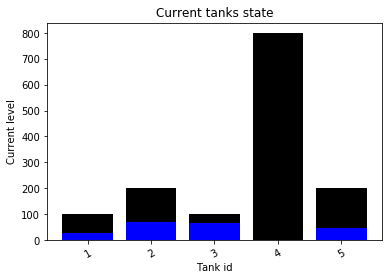

In [14]:
test_Q()
#print(np.mean(test_rewards_list) )

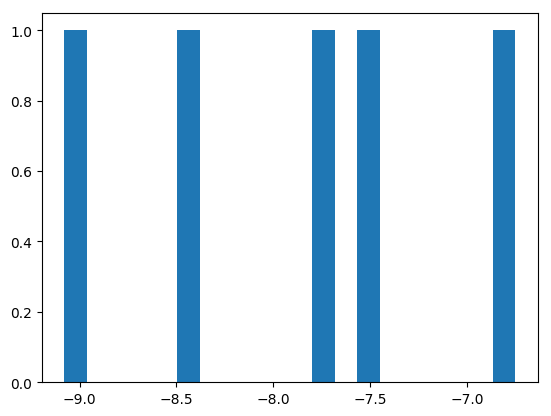

In [15]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

In [16]:
# Visualizing test simulation:

# test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
# HTML(test_anim.to_html5_video())


/home/user/envs/rl/lib/python3.5/site-packages/pandas/core/series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


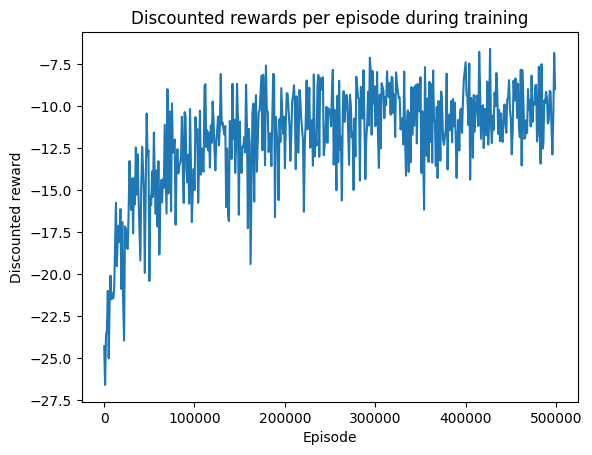

In [21]:
# Visualizing train simulation:

# episode =episodes
#simulation_id = 2
# step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

indices = [i for i in range(0,episodes,10)]

plt.plot(discrewards['episode'][indices],discrewards['discreward'][indices], label = "Discounted rewards")
plt.title("Discounted rewards per episode during training")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")
plt.savefig(simulation_directory + '/discounted-rewards-sim' + '{}'.format(simulation_id) + '.pdf')

plt.show()
plt.close()


### Test visualization

In [21]:
def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        level_counts_list):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    tanks = test_toy_system.tanks
    
    def my_indicator(x_min, x, x_max):
            if (x> x_min) & (x<=x_max):
                return 1
            else: 
                return 0
    def is_empty(x):
        if x <=0:
            return 1
        else: 
            return 0
        
    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
            plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = tanks[i-1].level_percentages           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length+1,5))
        ##################### Count number of times the system is in (0,b), (b,c),(c,e),(e,1) ##########
        b = percentages[0]
        level_counts = np.zeros(5, dtype = np.int64)
        
        x_mins = np.array([0,b,c,e])*tanks[i-1].max_load
        x_maxs = np.array([b,c,e,1])*tanks[i-1].max_load

        for x in states:
            level_counts[0] = level_counts[0] + is_empty(x)
            for j in range(1,5):
                level_counts[j] = level_counts[j] + my_indicator(x_mins[j-1], x, x_maxs[j-1])
            
        level_counts_list.append(level_counts)



    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + '{}'.format(simulation_id) + '.pdf')
    plt.show()
    plt.close()


## Simulations

In [25]:

def test_simulation(simulation_id,
                   max_episodes,
                   n_episodes = 1,
                   noise = False):
    
    # Initialize directories and files
    
    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
    
    with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

    # Initialize system
    episodes = max_episodes#100000

    tanks, trucks, graph, weights_matrix = initialize_test_system(noise, seed =episodes+1)
    test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

    Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))


    test_episodes = n_episodes
    episode_length =30
    test_freq = 1
    test_verbose = True
    test_visualization_steps = []
    test_rewards_list = []
    test_level_rewards_list = []
    test_transport_rewards_list = []
    test_trucks_sent_list = []
    test_number_of_first_trucks_sent_list = []
    test_number_of_second_trucks_sent_list = []
    test_number_of_trucks_not_deliverying_list = []
    
    test_level_counts_list = []
    
        
    test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list = test_number_of_first_trucks_sent_list,           
           number_of_second_trucks_sent_list=test_number_of_second_trucks_sent_list, 
           number_of_trucks_not_deliverying_list = test_number_of_trucks_not_deliverying_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q 
          )
            
    visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        test_level_counts_list)   
    print("Total discounted rewards","Level rewards", "Transport rewards")
    print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
    print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)

    #     if n_episodes == 1:
    first_type = sum(test_number_of_first_trucks_sent_list)/n_episodes
    print("Average 1st type Trucks sent to each shop:", first_type)
    print("Average 1st type Trucks sent:", sum(first_type[0:n] ) )

    second_type = sum(test_number_of_second_trucks_sent_list)/n_episodes
    print("Average 2nd type Trucks sent to each shop:", second_type)
    print("Average 2nd type Trucks sent:",  sum(second_type[0:n] ))

    print("Average number of trucks not deliverying:", sum(test_number_of_trucks_not_deliverying_list)/n_episodes )

    for i in range(n):
            print("Average level counts for shop {}:".format(i), test_level_counts_list[i]/n_episodes )


    print("Average total level counts:", sum(test_level_counts_list)/n_episodes )
    print("Percentage total level counts:", (sum(test_level_counts_list)/n_episodes)/(episode_length * n) * 100 )

    
test_episodes = 10

### Deterministic consumption rates without transport/unload costs, 0.5M episodes 

Test episode: 1
Episode 1 t 0 -1333.8216445 -1333.8216445 0.0 5500
Episode 1 t 1 -498.4153942 -498.4153942 0.0 5500
Episode 1 t 2 -858.0806194 -294.7068994 563.37372 4500
Episode 1 t 3 -550.7873265 -435.2234865 115.56384 0500
Episode 1 t 4 -1007.720639 -444.346919 563.37372 4500
Episode 1 t 5 -967.2909193 -382.2489793 585.04194 2500
Episode 1 t 6 -721.0033138 -157.6295938 563.37372 4500
Episode 1 t 7 -1082.187069 -1082.187069 0.0 5500
Episode 1 t 8 -5813.6394704 -5698.0756304 115.56384 0500
Episode 1 t 9 -1000845.8890898 -1000282.5153698 563.37372 4500
Episode 1 t 10 -1000594.5145146 -1000031.1407946 563.37372 4500
Episode 1 t 11 -1001420.6091575 -1000835.5672175 585.04194 2500
Episode 1 t 12 -1001796.8166806 -1001681.2528406 115.56384 0500
Episode 1 t 13 -1000729.7176792 -1000166.3439592 563.37372 4500
Episode 1 t 14 -1000550.7182327 -999987.3445127 563.37372 4500
Episode 1 t 15 -1000589.7869891 -1000589.7869891 0.0 5500
Episode 1 t 16 -1001258.9207996 -1001143.3569596 115.56384 0500


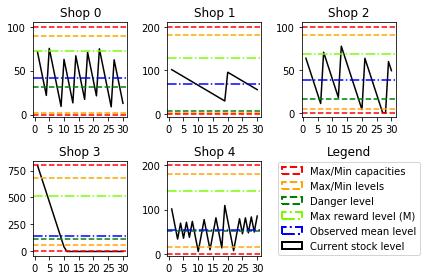

Total discounted rewards Level rewards Transport rewards
-3597772.4918564106 -23022037.77727931 11530.072589999998
Average trucks sent:  25.0
Average 1st type Trucks sent to each shop: [ 7.  1.  4.  0. 12.  6.]
Average 1st type Trucks sent: 24.0
Average 2nd type Trucks sent to each shop: [ 0.  0.  0.  0.  1. 29.]
Average 2nd type Trucks sent: 1.0
Average number of trucks not deliverying: 0.0
Average level counts for shop 0: [ 0.  0. 11. 19.  0.]
Average level counts for shop 1: [ 0.  0.  0. 30.  0.]
Average level counts for shop 2: [ 1.  2.  3. 24.  0.]
Average level counts for shop 3: [20.  1.  0.  7.  2.]
Average level counts for shop 4: [ 0.  4. 13. 13.  0.]
Average total level counts: [21.  7. 27. 93.  2.]
Percentage total level counts: [14.          4.66666667 18.         62.          1.33333333]


In [26]:
test_simulation(simulation_id=simulation_id, max_episodes = 5*10**5,n_episodes =1)


Test episode: 1
Test episode: 2
Test episode: 3
Test episode: 4
Test episode: 5
Test episode: 6
Test episode: 7
Test episode: 8
Test episode: 9
Test episode: 10
Test episode: 11
Test episode: 12
Test episode: 13
Test episode: 14
Test episode: 15
Test episode: 16
Test episode: 17
Test episode: 18
Test episode: 19
Test episode: 20
Test episode: 21
Test episode: 22
Test episode: 23
Test episode: 24
Test episode: 25
Test episode: 26
Test episode: 27
Test episode: 28
Test episode: 29
Test episode: 30
Test episode: 31
Test episode: 32
Test episode: 33
Test episode: 34
Test episode: 35
Test episode: 36
Test episode: 37
Test episode: 38
Test episode: 39
Test episode: 40
Test episode: 41
Test episode: 42
Test episode: 43
Test episode: 44
Test episode: 45
Test episode: 46
Test episode: 47
Test episode: 48
Test episode: 49
Test episode: 50
Test episode: 51
Test episode: 52
Test episode: 53
Test episode: 54
Test episode: 55
Test episode: 56
Test episode: 57
Test episode: 58
Test episode: 59
Test e

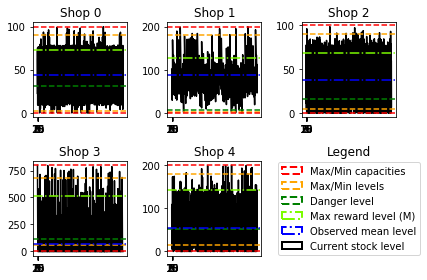

Total discounted rewards Level rewards Transport rewards
-6051478.69382935 -27700997.09935793 11328.970872000002
Average trucks sent:  24.45
Average 1st type Trucks sent to each shop: [6.740e+00 9.000e-01 3.900e+00 1.000e-02 1.191e+01 6.540e+00]
Average 1st type Trucks sent: 23.46
Average 2nd type Trucks sent to each shop: [0.000e+00 0.000e+00 1.000e-02 2.400e-01 7.400e-01 2.901e+01]
Average 2nd type Trucks sent: 0.99
Average number of trucks not deliverying: 0.01
Average level counts for shop 0: [ 0.13  0.03  9.42 20.23  0.19]
Average level counts for shop 1: [0.000e+00 2.000e-02 4.000e-02 2.964e+01 3.000e-01]
Average level counts for shop 2: [ 2.3   0.89  2.92 23.78  0.11]
Average level counts for shop 3: [22.99  0.88  0.66  5.13  0.34]
Average level counts for shop 4: [ 0.88  2.24 13.28 13.48  0.12]
Average total level counts: [26.3   4.06 26.32 92.26  1.06]
Percentage total level counts: [17.53333333  2.70666667 17.54666667 61.50666667  0.70666667]


In [24]:
test_simulation(simulation_id=simulation_id, max_episodes = 5*10**5,n_episodes =100)
